# Analysis of Airbnb data from European cities 

## 0. Introduction

This is a data analysis exercise for *Data-Driven Sustainability: Analysing Sustainability Issues with Python* class at Leuphana University. It's aim is to practice data handling, inspection, exploration, visualisation and statistical testing.

[Data Source](https://docs.google.com/spreadsheets/d/1ecopK6oyyb4d_7-QLrCr8YlgFrCetHU7-VQfnYej7JY/edit?usp=sharing) | [Research Paper](https://www.sciencedirect.com/science/article/pii/S0261517721000388) | [Instructions](https://docs.google.com/document/d/1nFQ-BppcPBVaK434H9zj0g_ByYq0vAFf88tv6pSIF54/edit?tab=t.0)

## 1. Importing libraries and dataset

In [1]:
!pip install folium

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import scipy.stats as stats
from scipy.stats import pearsonr
import statsmodels.api as sm

In [3]:
# base Google Sheets URL for direct import
base_url = "https://docs.google.com/spreadsheets/d/1ecopK6oyyb4d_7-QLrCr8YlgFrCetHU7-VQfnYej7JY/export?format=csv&gid="

# list of GIDs for each sheet
gids = ["1813557111", "1671143450", "1474041232", "993539767", "295085637", 
        "305266500", "1009970054", "1739828988", "1438277999", "1326018133",
        "82202766", "1355881051", "9179440", "58206735", "1452107999", 
        "1803477090", "1127044053", "1238155247", "671930913", "1950822222"]

# list of corresponding sheet names
sheet_names = ["amsterdam_weekdays", "amsterdam_weekends", "athens_weekdays", "athens_weekends", "berlin_weekends", 
               "berlin_weekdays", "barcelona_weekdays", "barcelona_weekends", "budapest_weekdays", "budapest_weekends", 
               "lisbon_weekdays", "lisbon_weekends", "london_weekdays", "london_weekends", "paris_weekdays",
               "paris_weekends", "rome_weekdays", "rome_weekends", "vienna_weekdays", "vienna_weekends"]

# mapping cities to countries
city_to_country = {
    "amsterdam": "Netherlands",
    "athens": "Greece",
    "berlin": "Germany",
    "barcelona": "Spain",
    "budapest": "Hungary",
    "lisbon": "Portugal",
    "london": "Great Britain",
    "paris": "France",
    "rome": "Italy",
    "vienna": "Austria"
}

# read all sheets into a list of dataframes, add 'city', 'day_type' and 'country' columns
dataframes = [
    pd.read_csv(base_url + gid)
    .assign(
        city=sheet.split('_')[0].title(),  # extract city from the sheet name, capitalize first letter
        day_type=sheet.split('_')[1],  # extract weekday/weekend from the sheet name
        country=city_to_country.get(sheet.split('_')[0])  # map city to country
    )
    for gid, sheet in zip(gids, sheet_names)
]

# merge all sheets into one DataFrame
df = pd.concat(dataframes, ignore_index=True)

In [4]:
# display the first 5 rows of the dataframe
df.head()

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,...,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type,country
0,0,194.033698,Private room,False,True,2,False,1,0,10,...,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,weekdays,Netherlands
1,1,344.245776,Private room,False,True,4,False,0,0,8,...,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,weekdays,Netherlands
2,2,264.101422,Private room,False,True,2,False,0,1,9,...,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,weekdays,Netherlands
3,3,433.529398,Private room,False,True,4,False,0,1,9,...,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,weekdays,Netherlands
4,4,485.552926,Private room,False,True,2,True,0,0,10,...,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,weekdays,Netherlands


## 2. Data cleaning and preparation

### 2.1 Renaming and deleting unnecessary columns

In [5]:
# columns before cleaning
print(df.columns)

Index(['Unnamed: 0', 'realSum', 'room_type', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat', 'city', 'day_type', 'country'],
      dtype='object')


In [6]:
# rename the 'realSum' column to 'price'
df.rename(columns={'realSum': 'price'}, inplace=True)

In [7]:
# remove the first column
df.drop(df.columns[0], axis=1, inplace=True)

In [8]:
# columns after cleaning
print(df.columns)

Index(['price', 'room_type', 'room_shared', 'room_private', 'person_capacity',
       'host_is_superhost', 'multi', 'biz', 'cleanliness_rating',
       'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist',
       'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng',
       'lat', 'city', 'day_type', 'country'],
      dtype='object')


### 2.2 Addressing missig values and duplicates

In [9]:
# show total number of missing values
df.isna().sum().sum()

0

In [10]:
# show total amount of duplicates
df.duplicated().sum()

0

Nothing to do!

### 2.3 Checking datatypes

In [11]:
# check the data types of the columns
df.dtypes

price                         float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity                 int64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating              int64
guest_satisfaction_overall      int64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
city                           object
day_type                       object
country                        object
dtype: object

Nothing to do here - all the columns have a correct datatype.

### 2.4 Creating new columns

Creating a column describing the number of listings that the host of the selected listing has, according to the information in the research paper.

In [12]:
# assign based on coditions from the paper
def assign_hosts_listings(row):
    if row['multi'] == 1:
        return "2-4 listings"
    elif row['biz'] == 1:
        return "more than 4 listings"
    elif row['multi'] == 0 and row['biz'] == 0:
        return "1 listing"
    else:
        return "Unknown"

# apply the function
df['hosts_listings'] = df.apply(assign_hosts_listings, axis=1)

# check if it worked
print(df[['multi', 'biz', 'hosts_listings']].head())

   multi  biz        hosts_listings
0      1    0          2-4 listings
1      0    0             1 listing
2      0    1  more than 4 listings
3      0    1  more than 4 listings
4      0    0             1 listing


### 2.4 Checking summary statistics for outliers

In [13]:
df.describe()

,price,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128
std,327.948386,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263
min,34.779339,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000
25%,148.752174,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510
50%,211.343089,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690
75%,319.694286,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885
max,18545.450280,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410


The numbers are plausible - it seems that there are no outliers or numbers out of a correct range in the dataset.

## 3. Exploratory questions

### 3.1 How many listings are in each city in total and also per type of day?

In [14]:
# number of listings per city and day type
city_day_type_count = df.groupby(['city', 'day_type']).size().reset_index(name='listing_count')

# number of listings per city 
city_total_count = df.groupby('city').size().reset_index(name='listing_count')

# Display the results
print(city_day_type_count)
print(city_total_count)

         city  day_type  listing_count
0   Amsterdam  weekdays           1103
1   Amsterdam  weekends            977
2      Athens  weekdays           2653
3      Athens  weekends           2627
4   Barcelona  weekdays           1555
5   Barcelona  weekends           1278
6      Berlin  weekdays           1284
7      Berlin  weekends           1200
8    Budapest  weekdays           2074
9    Budapest  weekends           1948
10     Lisbon  weekdays           2857
11     Lisbon  weekends           2906
12     London  weekdays           4614
13     London  weekends           5379
14      Paris  weekdays           3130
15      Paris  weekends           3558
16       Rome  weekdays           4492
17       Rome  weekends           4535
18     Vienna  weekdays           1738
19     Vienna  weekends           1799
        city  listing_count
0  Amsterdam           2080
1     Athens           5280
2  Barcelona           2833
3     Berlin           2484
4   Budapest           4022
5     Lisbon 

### 3.2 Which city has the biggest proportion of superhosts?

In [15]:
# step 1: create a function that caluclates superhost proportion for each city

def calculate_superhost_proportion(df, city_name):
    # filter for given city
    city_data = df[df['city'] == city_name]
    
    # calculate the total number of listings in the city
    total_listings = city_data.shape[0]
    
    # calculate the number of superhost listings (host_is_superhost==True)
    superhost_listings = city_data[city_data['host_is_superhost'] == True].shape[0]
    
    # calculate the proportion of superhosts (superhost listings / total listings)
    if total_listings > 0: # to not divide by 0 just in case
        superhost_proportion = superhost_listings / total_listings
    else:
        superhost_proportion = 0
    
    return superhost_proportion

# step 2: iterate through cities and save result

# get the unique city names
cities = df['city'].unique()

# initialize an empty dictionary to store the results
superhost_proportions = {}

# iterate through cities and save result in dictionary
for city in cities:
    proportion = calculate_superhost_proportion(df, city)
    # store the result in the dictionary with the city name as the key
    superhost_proportions[city] = proportion

# step 3: find the city with max value of proportion

max_city = max(superhost_proportions, key=superhost_proportions.get)
max_proportion = superhost_proportions[max_city]

print(f"The city with the highest proportion of superhosts is {max_city} with a proportion of {max_proportion:.2f}")

The city with the highest proportion of superhosts is Athens with a proportion of 0.43


### 3.3 Which cities have listings with more than four rooms?

In [16]:
# filter for listings with more than 4 rooms
filtered_df = df[df['bedrooms'] > 4]

# get the unique cities that have such listings
cities_with_more_than_four_rooms = filtered_df['city'].unique()

print("Cities with listings having more than 4 rooms:")
print(cities_with_more_than_four_rooms)

Cities with listings having more than 4 rooms:
['Amsterdam' 'Berlin' 'Barcelona' 'Lisbon' 'London' 'Paris' 'Rome']


### 3.4 Which city has the most entire home/apt type listings?

In [17]:
# filter for listings that are of type "Entire home/apt"
entire_home_df = df[df['room_type'] == 'Entire home/apt']

# group by city and count the number of listings
city_counts = entire_home_df['city'].value_counts()

# find the city with the maximum number
max_city = city_counts.idxmax()
max_count = city_counts.max()

print(f"The city with the most 'Entire home/apt' listings is {max_city} with {max_count} listings.")

The city with the most 'Entire home/apt' listings is Rome with 5561 listings.


### 3.5 Are ratings typically high across listings, or is there a wide variation?

One way to analyze variation of the ratings is to visualise a histogram:

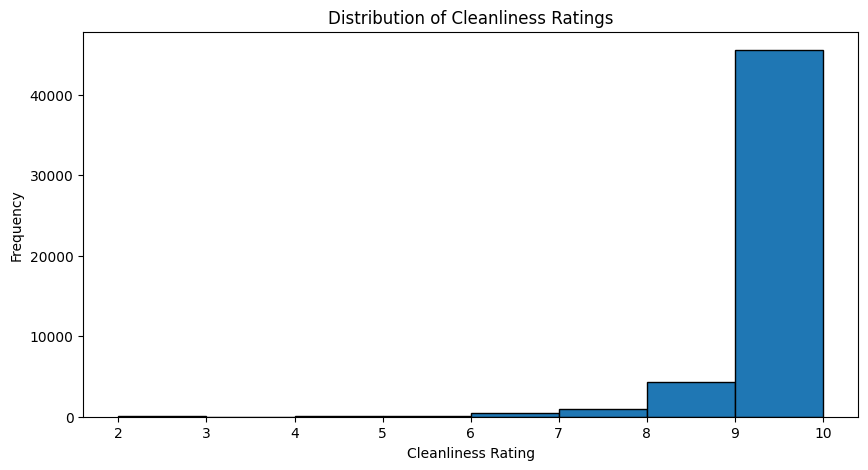

In [18]:
# plot a histogram to visualize the distribution of ratings for cleanliness_rating
plt.figure(figsize=(10, 5))
plt.hist(df['cleanliness_rating'].dropna(), bins=8, edgecolor='black') # bins=8 -> ratings vary from 2 to 10
plt.title('Distribution of Cleanliness Ratings')
plt.xlabel('Cleanliness Rating')
plt.ylabel('Frequency')
plt.show()

Interpretation: Cleanliness ratings are typically high.

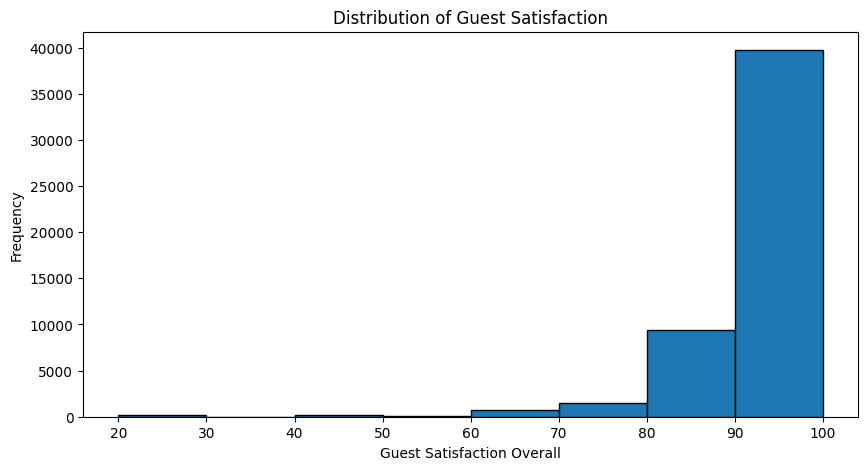

In [19]:
# plot a histogram to visualize the distribution of ratings for guest_satisfaction_overall
plt.figure(figsize=(10, 5))
plt.hist(df['guest_satisfaction_overall'].dropna(), bins=8, edgecolor='black') 
plt.title('Distribution of Guest Satisfaction')
plt.xlabel('Guest Satisfaction Overall')
plt.ylabel('Frequency')
plt.show()

Guest satisfaction ratings are also typically high.

### 3.6 How does person_capacity vary across listings? What is the most common capacity of listings?

Variety of person_capacity can be visualised with a histogram:

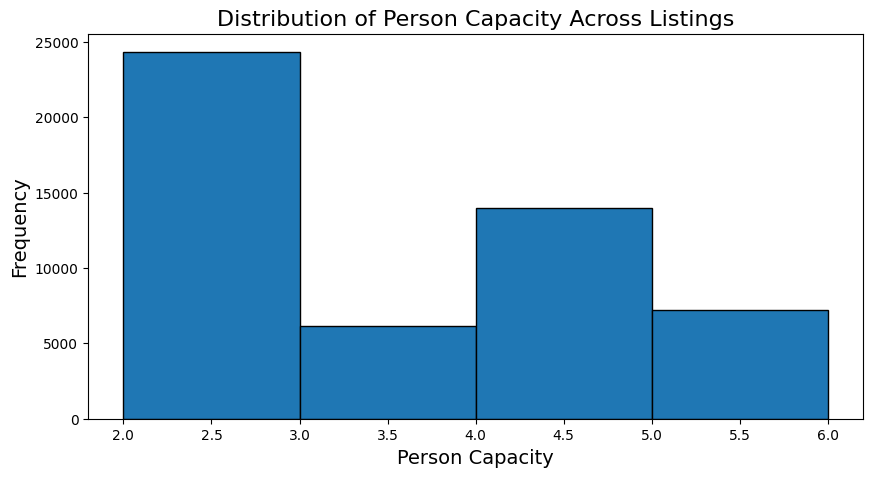

In [20]:
# plot histogram for person_capacity to see the distribution
plt.figure(figsize=(10, 5))
plt.hist(df['person_capacity'].dropna(), bins=4, edgecolor='black') 
plt.title('Distribution of Person Capacity Across Listings', fontsize=16)
plt.xlabel('Person Capacity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

Seems that the most common capacity is 2, that can be confirmed by finding the mode (most common value)

In [21]:
# find the most common capacity (mode)
most_common_capacity = df['person_capacity'].mode()[0]

print(f"The most common person capacity across listings is: {most_common_capacity}")

The most common person capacity across listings is: 2


### 3.7a Distribution of price according to type of day


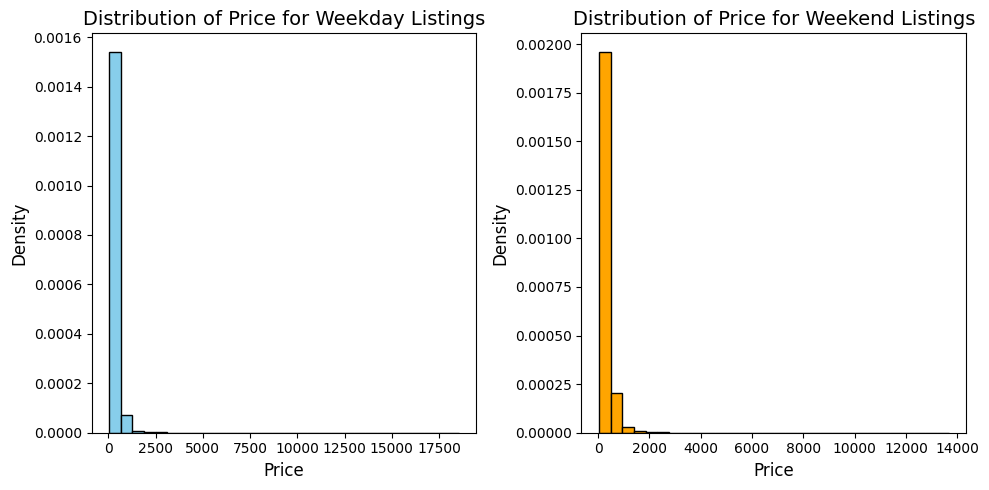

In [22]:
# separate the data into weekday and weekend listings
weekday_data = df[df['day_type'] == 'weekdays']['price']
weekend_data = df[df['day_type'] == 'weekends']['price']

plt.figure(figsize=(10, 5))

# histogram for weekday listings in the first subplot
plt.subplot(1, 2, 1)
plt.hist(weekday_data.dropna(), bins=30, color='skyblue', edgecolor='black', density=True)
plt.title('Distribution of Price for Weekday Listings', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Density', fontsize=12)

# histogram for weekend listings 
plt.subplot(1, 2, 2)
plt.hist(weekend_data.dropna(), bins=30, color='orange', edgecolor='black', density=True)
plt.title('Distribution of Price for Weekend Listings', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

Both of the histograms are **right skewed** and **unimodal**.

### 3.7b Distribution of price according to type of day after logarithmic transformation

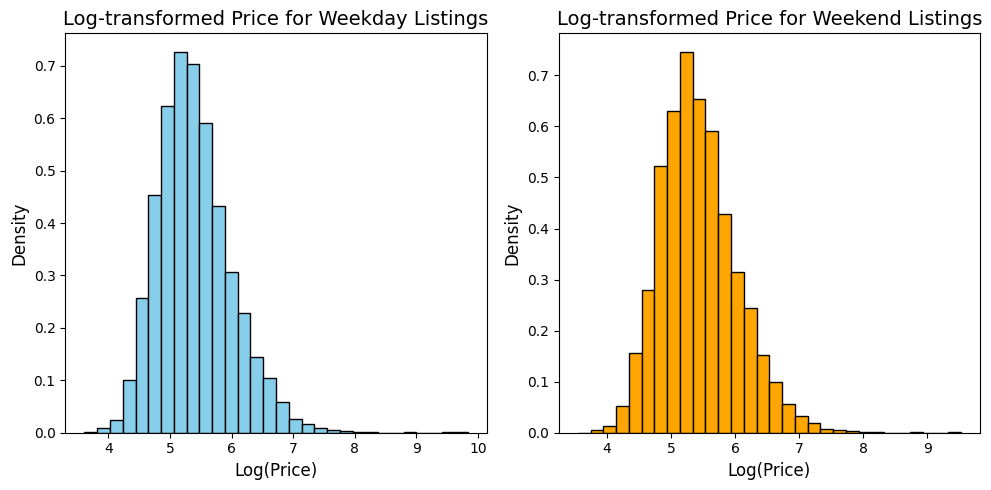

In [23]:
# log transformation on price data
weekday_data_log = np.log(weekday_data[weekday_data > 0]) 
weekend_data_log = np.log(weekend_data[weekend_data > 0])

plt.figure(figsize=(10, 5))

# histogram for log-transformed weekday listings
plt.subplot(1, 2, 1)
plt.hist(weekday_data_log.dropna(), bins=30, color='skyblue', edgecolor='black', density=True)
plt.title('Log-transformed Price for Weekday Listings', fontsize=14)
plt.xlabel('Log(Price)', fontsize=12)
plt.ylabel('Density', fontsize=12)

# histogram for log-transformed weekend listings
plt.subplot(1, 2, 2)
plt.hist(weekend_data_log.dropna(), bins=30, color='orange', edgecolor='black', density=True)
plt.title('Log-transformed Price for Weekend Listings', fontsize=14)
plt.xlabel('Log(Price)', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

After logarithmic transformation, distribution of both histograms is still right skewed and unimodal.

### 3.8 Plot the distribution of guest_satisfaction_overall ratings

Step performed in step 3.5.

### 3.9 Examine the distribution of cleanliness_rating

Step performed in step 3.5.

## 4. Hypothesis testing

### 4.1 "Superhosts have higher guest satisfaction ratings compared to non-superhosts."

First, let's see what average ratings for non- and superhosts are.

In [24]:
# group by 'host_is_superhost' and calculate the average guest satisfaction
average_ratings = df.groupby('host_is_superhost')['guest_satisfaction_overall'].mean()
print(average_ratings)

host_is_superhost
False    91.159038
True     96.900242
Name: guest_satisfaction_overall, dtype: float64


Indeed superhosts have on average higher guest satisfaction ratings. To see how the data is distributed in more detail we can plot box plots for both grups and compare.

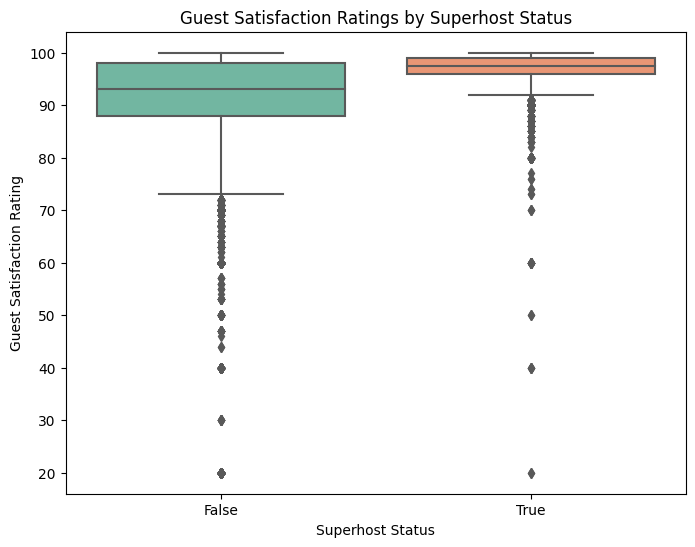

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='host_is_superhost', y='guest_satisfaction_overall', data=df, palette="Set2")
plt.title('Guest Satisfaction Ratings by Superhost Status')
plt.xlabel('Superhost Status')
plt.ylabel('Guest Satisfaction Rating')
plt.show()

Visualisation of box plots confirms out previous assumptions. To assure statistical relevance let's perform statistical testing:

In [26]:
# define the null and alternative hypotheses
H0 = "Superhosts have the same or lower average guest satisfaction ratings compared to non-superhosts."
H1 = "Superhosts have higher average guest satisfaction ratings compared to non-superhosts."

# separate the data into superhosts and non-superhosts
superhosts = df[df['host_is_superhost'] == 1]['guest_satisfaction_overall'].dropna()
non_superhosts = df[df['host_is_superhost'] == 0]['guest_satisfaction_overall'].dropna()

# perform a one-tailed independent t-test
t_stat, p_value = stats.ttest_ind(superhosts, non_superhosts, alternative='greater')

# print the results
print(f"H0 - {H0}")
print(f"H1 - {H1}")
print("Test statistic:", t_stat)
print("p-value:", p_value)

# conclusion
if p_value < 0.05:
    print(f"NULL HYPOTHESIS REJECTED")
    print(f"CONFIRMED: {H1}")
else:
    print("FAILED TO REJECT THE NULL HYPOTHESIS")
    print(f"CONFIRMED: {H0}")

H0 - Superhosts have the same or lower average guest satisfaction ratings compared to non-superhosts.
H1 - Superhosts have higher average guest satisfaction ratings compared to non-superhosts.
Test statistic: 66.3371678020877
p-value: 0.0
NULL HYPOTHESIS REJECTED
CONFIRMED: Superhosts have higher average guest satisfaction ratings compared to non-superhosts.


### 4.2 "Listings located closer to the metro have higher prices than those farther away."

Let's visualise a scatterplot with regression line:

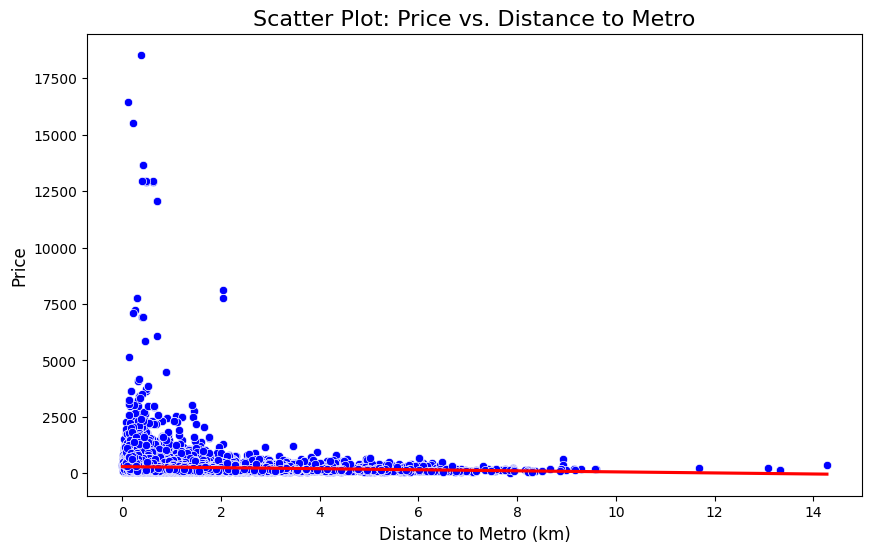

In [27]:
# extract relevant columns 
df_metro = df.dropna(subset=['price', 'metro_dist'])

# create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_metro, x='metro_dist', y='price', color='blue')

# add a regression line
sns.regplot(data=df_metro, x='metro_dist', y='price', scatter=False, color='red')

plt.title('Scatter Plot: Price vs. Distance to Metro', fontsize=16)
plt.xlabel('Distance to Metro (km)', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

It seems that there is slight negative correlation. We can perform a statistical test calculating correlation coefficient and p-value.

In [28]:
# calculate Pearson correlation
corr_stat, p_value = stats.pearsonr(df['price'], df['metro_dist'])

# print results
print("Correlation coefficient:", corr_stat)
print("P-value:", p_value)

print("Interpretation:")

# interpretation based on the value of correlation
if corr_stat > 0.7:
    print("There is a strong positive correlation between price and metro distance.")
elif corr_stat > 0.3:
    print("There is a moderate positive correlation between price and metro distance.")
elif corr_stat > 0:
    print("There is a weak positive correlation between price and metro distance.")
elif corr_stat == 0:
    print("There is no linear correlation.")
elif corr_stat < -0.7:
    print("There is a strong negative correlation between price and metro distance.")
elif corr_stat < -0.3:
    print("There is a moderate negative correlation between price and metro distance.")
else:
    print("There is a weak negative correlation between price and metro distance.")
    
# conclusion based on p-value
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Correlation coefficient: -0.061024567777704625
P-value: 7.37649434157553e-44
Interpretation:
There is a weak negative correlation between price and metro distance.
The correlation is statistically significant.


### 4.3 "Southern cities tend to have more entire home/apartment listings, while northern cities have more private and shared room listings."

First let's calculate propotions of each room type for southern and northern cities separately:

In [29]:
# divide cities into southern and northern
southern_cities = ['Athens', 'Barcelona', 'Lisbon', 'Rome']
northern_cities = ['Amsterdam', 'Berlin', 'Budapest', 'London', 'Paris', 'Vienna']

# filter the dataframe to include only the cities of interest
df_southern = df[df['city'].isin(southern_cities)]
df_northern = df[df['city'].isin(northern_cities)]

# calculate the total proportion of each room type for Southern cities
southern_room_type_proportions = df_southern['room_type'].value_counts(normalize=True)

# calculate the total proportion of each room type for Northern cities
northern_room_type_proportions = df_northern['room_type'].value_counts(normalize=True)

print("South proportions")
print(southern_room_type_proportions)
print("")
print("North proportions")
print(northern_room_type_proportions)

South proportions
Entire home/apt    0.648518
Private room       0.346723
Shared room        0.004759
Name: room_type, dtype: float64

North proportions
Entire home/apt    0.617796
Private room       0.373281
Shared room        0.008922
Name: room_type, dtype: float64


Then visualise them as stacked bars:

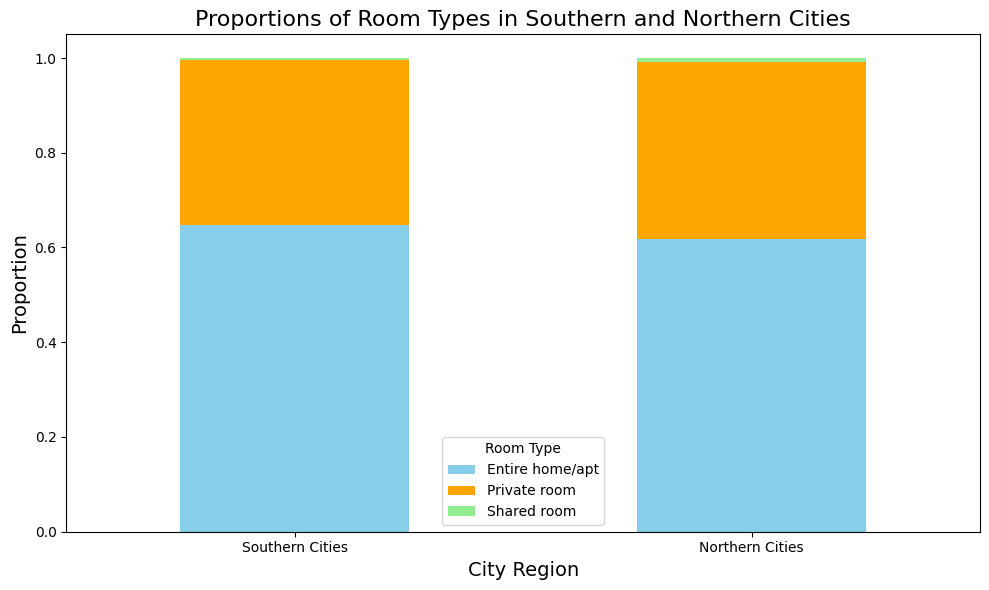

In [30]:
# create a new dataframe with the proportions
proportions_df = pd.DataFrame({
    'Entire home/apt': [southern_room_type_proportions.get('Entire home/apt', 0), northern_room_type_proportions.get('Entire home/apt', 0)],
    'Private room': [southern_room_type_proportions.get('Private room', 0), northern_room_type_proportions.get('Private room', 0)],
    'Shared room': [southern_room_type_proportions.get('Shared room', 0), northern_room_type_proportions.get('Shared room', 0)],
}, index=['Southern Cities', 'Northern Cities'])

# plotting the stacked bar chart
proportions_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange', 'lightgreen'])
plt.title('Proportions of Room Types in Southern and Northern Cities', fontsize=16)
plt.xlabel('City Region', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()

Indeed, within Southern cities, entire homes and apartments occupy a larger share compared to Northern cities, but is the difference significant? We can test it with chi squared test:

In [31]:
H0 = "There is no difference in the distribution of room types between southern and northern cities."
H1 = "The distribution of room types is different between southern and northern cities."

# create a new column to identify whether the city is southern or northern
df['city_group'] = df['city'].apply(lambda x: 'Southern' if x in southern_cities else ('Northern' if x in northern_cities else 'Other'))

# filter data to only include southern and northern cities
df_southern_northern = df[df['city_group'].isin(['Southern', 'Northern'])]

# create the contingency table: row: city group, column: room type
contingency_table = pd.crosstab(df_southern_northern['city_group'], df_southern_northern['room_type'])

print(contingency_table)

# chi-squared test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("\nChi-squared test results:")
print(f"Chi-squared statistic: {chi2_stat}")
print(f"p-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies table:\n{expected}")

# conclusion
if p_value < 0.05:
    print("Reject the null hypothesis.")
    print(f"Conclusion: {H1}")
else:
    print("Fail to reject the null hypothesis.")
    print(f"Conclusion: {H0}")

room_type   Entire home/apt  Private room  Shared room
city_group                                            
Northern              17795         10752          257
Southern              14853          7941          109

Chi-squared test results:
Chi-squared statistic: 75.20361788948422
p-value: 4.674572132800783e-17
Degrees of freedom: 2
Expected frequencies table:
[[18186.95712379 10413.15821842   203.88465778]
 [14461.04287621  8279.84178158   162.11534222]]
Reject the null hypothesis.
Conclusion: The distribution of room types is different between southern and northern cities.


### 5.4 "There is a stronger positive correlation between guest satisfaction and restaurant index within Southern cities that within Northern cities."

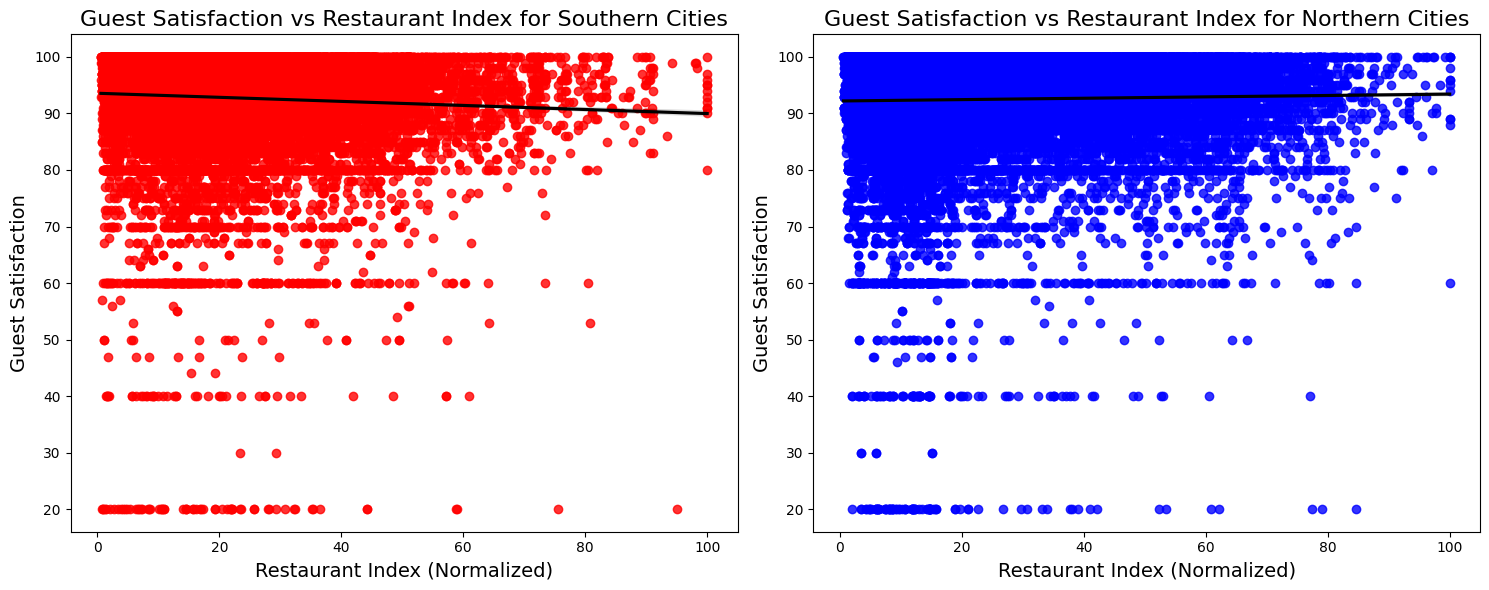

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# scatter plot for southern cities
sns.regplot(data=df_southern, x='rest_index_norm', y='guest_satisfaction_overall', ax=axes[0], scatter_kws={'color':'red'}, line_kws={'color':'black'})
axes[0].set_title("Guest Satisfaction vs Restaurant Index for Southern Cities", fontsize=16)
axes[0].set_xlabel('Restaurant Index (Normalized)', fontsize=14)
axes[0].set_ylabel('Guest Satisfaction', fontsize=14)

# scatter plot for northern cities
sns.regplot(data=df_northern, x='rest_index_norm', y='guest_satisfaction_overall', ax=axes[1], scatter_kws={'color':'blue'}, line_kws={'color':'black'})
axes[1].set_title("Guest Satisfaction vs Restaurant Index for Northern Cities", fontsize=16)
axes[1].set_xlabel('Restaurant Index (Normalized)', fontsize=14)
axes[1].set_ylabel('Guest Satisfaction', fontsize=14)

# tight layout for proper spacing
plt.tight_layout()
plt.show()

At the first glance, it seems that it's the contrary. Statistical testing:

In [33]:
# H0 = "There is no correlation between guest satisfaction and restaurant index"
# H1 = "There is a stronger positive correlation between guest satisfaction and restaurant index within Southern cities that within Northern cities."

corr, p_value = pearsonr(df['rest_index_norm'], df['guest_satisfaction_overall'])
corr_southern, p_value_southern = pearsonr(df_southern['rest_index_norm'], df_southern['guest_satisfaction_overall'])
corr_northern, p_value_northern = pearsonr(df_northern['rest_index_norm'], df_northern['guest_satisfaction_overall'])

# conclusion based on p-value
if p_value < 0.05:
    print("The correlation between guest satisfaction and restaurant index is statistically significant.")
    if corr_southern > 0:
        print("The correlation is for Southern cities is positive")
        if courr_southern > corr_northern:
            print("The correlation is for Southern cities is positive and higher than for Southern than for Northern cities, confirming the hypothesis.")
    else:
        print("The correlation for Southern cities is negative, H1 is rejected.")
else:
    print("The correlation is not statistically significant.")

The correlation between guest satisfaction and restaurant index is statistically significant.
The correlation for Southern cities is negative, H1 is rejected.


## 5. Airbnb and gentrification

**Gentrification** is process where wealthier people move into a previously lower-income neighborhood, often leading to higher property values and rents. Airbnb can play a significant role in it by increasing demand for short-term rentals in certain neighborhoods.

### 5.1 Berlin - location of the most expensive Airbnb listings

To take **Berlin** as an example, neighborhoods that are most often regarded as gentrified or gentrifying are: Kreuzberg, Friedrichshain, Neukölln, Prenzlauer Berg and Mitte. Let's see if any of 30 most expensive airbnb listings form Berlin are present in those neighborhoods.

In [34]:
berlin_df = df[df['city'] == 'Berlin']

# sort the data by 'price' in descending order to get the most expensive listings
most_expensive_berlin = berlin_df.sort_values(by='price', ascending=False).head(30)

# create a map centered around Berlin (latitude and longitude for Berlin)
berlin_map = folium.Map(location=[52.52, 13.4050], zoom_start=12)

# add markers for the most expensive listings
for index, row in most_expensive_berlin.iterrows():
    price = row['price']
    lat = row['lat']
    lng = row['lng']
    
    # create a popup with the listing's price
    popup = folium.Popup(f"Price: €{price}", parse_html=True)
    
    # add a marker to the map with the price as the label
    folium.CircleMarker(
        location=[lat, lng],
        radius=8,  # Size of the marker
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=popup
    ).add_to(berlin_map)

# display
berlin_map

At the first glance it's visible that a significat number of the most expensive airbnbs is located in those originally lower income neighborhoods.

### 5.2 Airbnb long term rent

What if we were to rent an airbnb as a long-term stay in examined cities? First, let's consider basic statistics of price per 2 nights by city:

In [35]:
city_price_stats = df.groupby('city')['price'].agg(['mean', 'median', 'min', 'max'])
print(city_price_stats)

                 mean      median         min           max
city                                                       
Amsterdam  573.112795  460.244182  128.887118   8130.668104
Athens     151.744121  127.715417   42.884259  18545.450280
Barcelona  293.753706  208.299393   69.588289   6943.700980
Berlin     244.583752  191.175096   64.971487   5857.483407
Budapest   176.513548  152.982093   34.779339   3751.233727
Lisbon     238.210479  225.375235   70.590994   1681.050657
London     362.469256  261.294951   54.328653  15499.894160
Paris      392.531403  317.597167   92.739305  16445.614690
Rome       205.391950  182.591822   46.057092   2418.348023
Vienna     241.582484  208.494028   63.576654  13664.305920


Excluding expensive listings for more realistic results:

In [36]:
df_cheaper = df[df['price'] <= 300]
city_price_stats_cheaper = df_cheaper.groupby('city')['price'].agg(['mean', 'median', 'min', 'max'])
print(city_price_stats_cheaper)

                 mean      median         min         max
city                                                     
Amsterdam  246.166626  251.915731  128.887118  299.721135
Athens     135.633931  127.363907   42.884259  299.252455
Barcelona  182.312311  178.276352   69.588289  299.532199
Berlin     177.479787  168.271478   64.971487  299.149294
Budapest   156.703562  149.927151   34.779339  299.619307
Lisbon     197.220111  203.330206   70.590994  299.953096
London     186.676528  180.389943   54.328653  299.865942
Paris      225.225027  231.615248   92.739305  299.655140
Rome       175.708632  172.772543   46.057092  299.955579
Vienna     192.013358  189.093799   63.576654  299.184255


Considering mean price per night and multiplying by 30 to get an approximation of how much would it cost to rent long term in each city.

In [37]:
# multiply mean by 15 (price is for 2 adults and 2 nights)
city_price_stats_cheaper['monthly_price'] = city_price_stats_cheaper['mean'] * 15
print(city_price_stats_cheaper[['monthly_price']])

           monthly_price
city                    
Amsterdam    3692.499391
Athens       2034.508968
Barcelona    2734.684661
Berlin       2662.196806
Budapest     2350.553436
Lisbon       2958.301665
London       2800.147916
Paris        3378.375410
Rome         2635.629479
Vienna       2880.200373


Those calculation by itself give an idea of how expensive would it be to rent in each city. Even more insight can be gained from box plots for each city and monthly price.

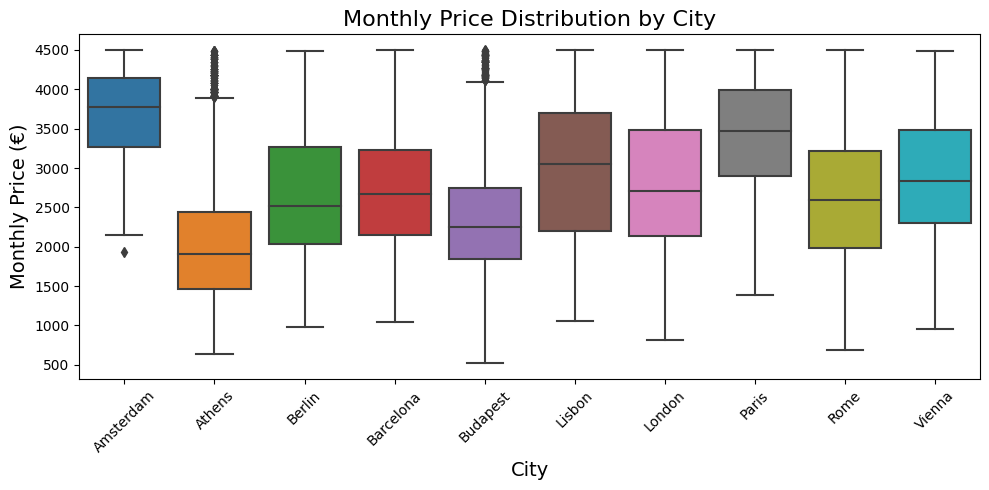

In [38]:
df_cheaper = df_cheaper.copy()  # create a copy, errors otherwise
df_cheaper['price_monthly'] = df_cheaper['price'] * 15  # monthly 'rent'

# create a box plot for 'price_monthly' grouped by 'city'
plt.figure(figsize=(10, 5))
sns.boxplot(x='city', y='price_monthly', data=df_cheaper)

# customize plot
plt.title('Monthly Price Distribution by City', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Monthly Price (€)', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Even in the cheapest cities, when considering long-term prices, most listings fall into the range that is attainable only for high-income individuals to pay.

### 5.3 Multi-property owners in the city center

Running the code below we'll see the key statistic measures for distance to the city center grouped by the number of listings a host has.

In [39]:
host_dist_stats = df.groupby('hosts_listings')['dist'].agg(['mean', 'median', 'min', 'max'])
print(host_dist_stats)

                          mean    median       min        max
hosts_listings                                               
1 listing             3.614762  3.059358  0.015045  22.617458
2-4 listings          3.316072  2.727484  0.076165  25.284557
more than 4 listings  2.654029  2.180431  0.039814  18.511822


By the mean and median themselves, it seems that host's with more than 4 listings (so likely making a business out of it) generally have their apartments closer to the city center. Again more insight can be gained visualising the data as box plots:

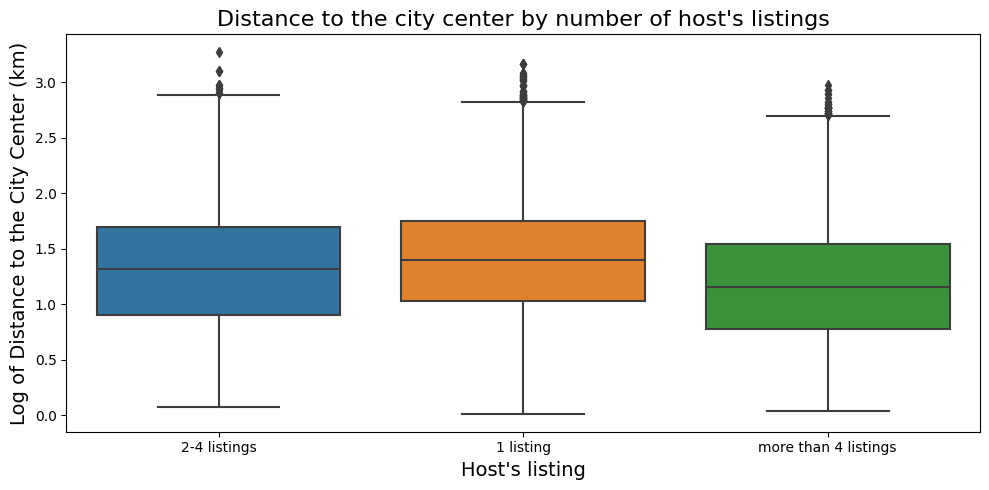

In [40]:
# apply a logarithmic transformation to the 'dist' column for better viewing
df['log_dist'] = np.log(df['dist'] + 1)  # adding 1 to avoid log(0)

# create a box plot 
plt.figure(figsize=(10, 5))
sns.boxplot(x='hosts_listings', y='log_dist', data=df)

# customize plot
plt.title("Distance to the city center by number of host's listings", fontsize=16)
plt.xlabel("Host's listing", fontsize=14)
plt.ylabel('Log of Distance to the City Center (km)', fontsize=14)

plt.tight_layout()
plt.show()

If we define "close to city center" as being not more than 1 kilometer away from the center, we'll get the following nominal values:

In [41]:
df['close_to_city_center'] = df['dist'] <= 1  # true if dist <= 1 km, False otherwise

# group by 'hosts_listings' and sum the number of listings close to the city center
close_to_city_counts = df.groupby('hosts_listings')['close_to_city_center'].sum()

# display
print(close_to_city_counts)

hosts_listings
1 listing               1656
2-4 listings            2067
more than 4 listings    3556
Name: close_to_city_center, dtype: int64


And the following distribution:

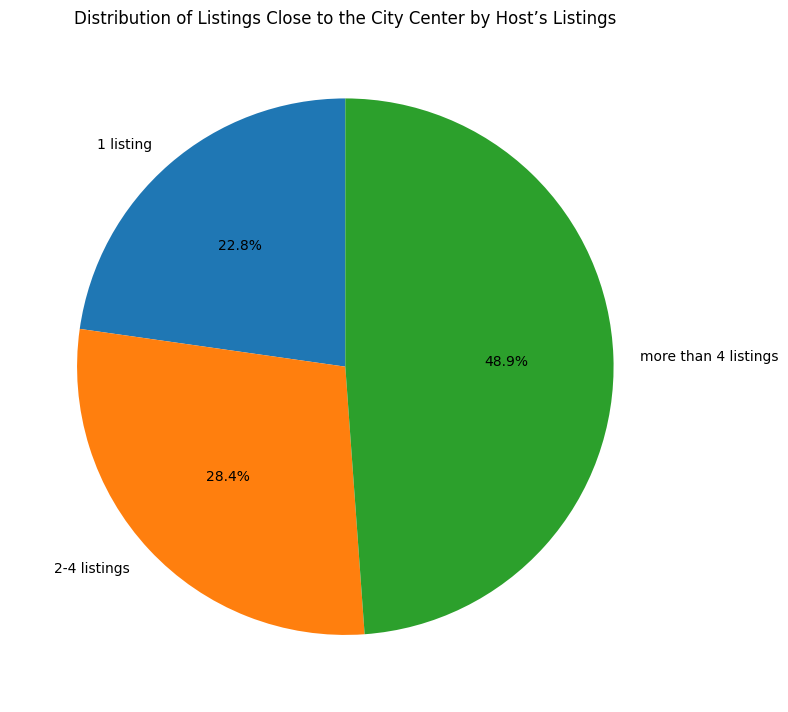

In [42]:
# pie chart
plt.figure(figsize=(8, 8))
close_to_city_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False)

plt.title('Distribution of Listings Close to the City Center by Host’s Listings')
plt.gca().get_yaxis().set_visible(False) # hide y axis
plt.tight_layout()
plt.show()

Among the listings that are close to the city center, **almost 50% belongs to hosts that have at least 4 listings.**

## 6. Limitations

Some of the limiations and missing information that could improve the analysis with regards to the gentrification phenomenon:

- The dataset **doesn’t contain information about the specific neighborhood** where the listing is located, making it difficult to draw conclusions about specific districts undergoing gentrification. By connecting it with geospatial city district boundary data, more in-depth analysis could be conducted to identify trends in particular areas.

- Although Airbnb prices were part of the analysis, the **relationship between these prices and rents or property values** is unclear. Without a comparison to the housing market, it’s impossible to fully assess Airbnb's impact on it.

- **Lack of temporal data:** Gentrification is a long-term process, and without data over a longer period of time, it’s difficult to identify meaningful trends.

- Airbnb listings may be **concentrated in certain types of neighborhoods,** which could skew the analysis.

- **Occupancy rate data would provide more accurate insights** into how often the listings are rented and offer a clearer picture of their actual impact on the housing market and local communities.